In [85]:
import pandas as pd
import numpy as np
import json
import re

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

In [86]:
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [87]:

# 1) Paths

CSV_PATH = "./data/bq-results-20260126-100828-1769422115577.csv"

TWEET_JSON_PATHS = [
    "./data/SOL_2025-12-29.json",
    "./data/SHIB_2025_12-29.json",
    "./data/FTM_2025-12-29.json",
    "./data/ETH_2025-12-29.json",
]

In [88]:

# 2) Time window: Jan 2026 (UTC)

JAN_START = pd.Timestamp("2026-01-24T00:00:00Z")
FEB_START = pd.Timestamp("2026-02-01T00:00:00Z")

In [89]:

# 3) Join bin size

BIN = "15min"  

In [90]:

# 4) Load data

PRICE = pd.read_csv(CSV_PATH)

def load_tweets(path):
    with open(path, "r") as f:
        data = json.load(f)
    return pd.DataFrame(data)

TWEETS = pd.concat([load_tweets(p) for p in TWEET_JSON_PATHS], ignore_index=True)

print("RAW PRICE:", PRICE.shape, "columns:", list(PRICE.columns))
print("RAW TWEETS:", TWEETS.shape, "columns:", list(TWEETS.columns))

RAW PRICE: (3444, 3) columns: ['symbol', 'price', 'timestamp']
RAW TWEETS: (468, 8) columns: ['id', 'text', 'author_id', 'crypto_key', 'created_at_raw', 'created_at_iso', 'timestamp_ms', 'timestamp_sec']


In [91]:

# 5) Parse timestamps 
# PRICE.timestamp is epoch in milliseconds

if "timestamp" not in PRICE.columns:
    raise ValueError("PRICE must have column 'timestamp'. Found: " + str(list(PRICE.columns)))

PRICE["timestamp"] = pd.to_numeric(PRICE["timestamp"], errors="coerce")
PRICE["event_timestamp"] = pd.to_datetime(PRICE["timestamp"], unit="ms", utc=True, errors="coerce")

# Tweets
TWEETS["timestamp_ms"] = pd.to_numeric(TWEETS.get("timestamp_ms"), errors="coerce")
TWEETS["tweet_ts"] = pd.to_datetime(TWEETS["timestamp_ms"], unit="ms", utc=True, errors="coerce")
TWEETS["created_at_iso"] = pd.to_datetime(TWEETS.get("created_at_iso"), utc=True, errors="coerce")

# Map symbol
TWEETS["symbol"] = TWEETS.get("crypto_key")

print("\nParsed time ranges:")
print("PRICE:", PRICE["event_timestamp"].min(), "->", PRICE["event_timestamp"].max())
print("TWEETS:", TWEETS["tweet_ts"].min(), "->", TWEETS["tweet_ts"].max())


Parsed time ranges:
PRICE: 2025-11-23 21:41:44.894000+00:00 -> 2026-01-25 18:52:56.065000+00:00
TWEETS: 2024-03-15 13:41:53+00:00 -> 2026-01-25 18:29:26+00:00


In [92]:

# 6) Filter to Jan 2026 only

PRICE_JAN = PRICE[(PRICE["event_timestamp"] >= JAN_START) & (PRICE["event_timestamp"] < FEB_START)].copy()
TWEETS_JAN = TWEETS[(TWEETS["tweet_ts"] >= JAN_START) & (TWEETS["tweet_ts"] < FEB_START)].copy()

print("\nJAN 2026 FILTER RESULTS")
print("PRICE_JAN:", PRICE_JAN.shape, "range:", PRICE_JAN["event_timestamp"].min(), "->", PRICE_JAN["event_timestamp"].max())
print("TWEETS_JAN:", TWEETS_JAN.shape, "range:", TWEETS_JAN["tweet_ts"].min(), "->", TWEETS_JAN["tweet_ts"].max())

print("\nSymbols in PRICE_JAN:", sorted(PRICE_JAN["symbol"].dropna().unique().tolist()) if "symbol" in PRICE_JAN.columns else "no symbol col")
print("Symbols in TWEETS_JAN:", sorted(TWEETS_JAN["symbol"].dropna().unique().tolist()))



JAN 2026 FILTER RESULTS
PRICE_JAN: (796, 4) range: 2026-01-25 18:02:56.638000+00:00 -> 2026-01-25 18:52:56.065000+00:00
TWEETS_JAN: (296, 10) range: 2026-01-24 14:21:22+00:00 -> 2026-01-25 18:29:26+00:00

Symbols in PRICE_JAN: ['ETH', 'FTM', 'SHIB', 'SOL']
Symbols in TWEETS_JAN: ['ETH', 'FTM', 'SHIB', 'SOL']


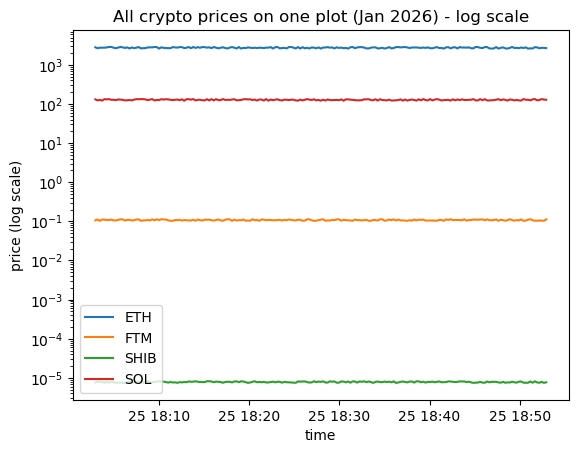

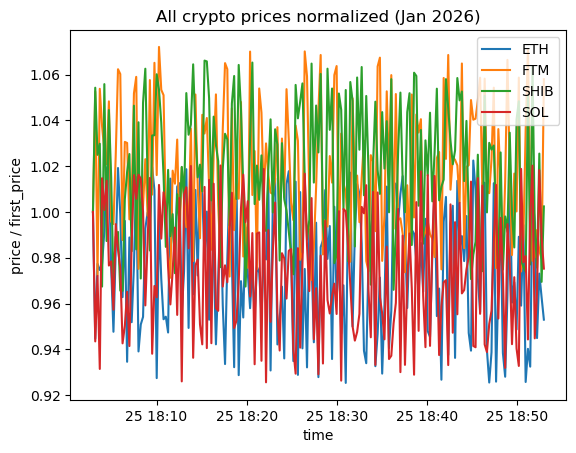

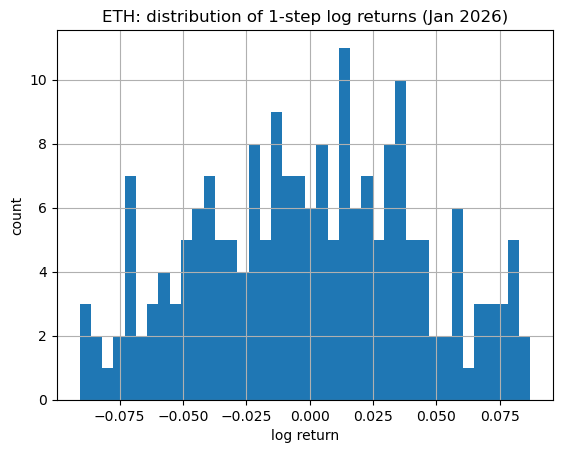

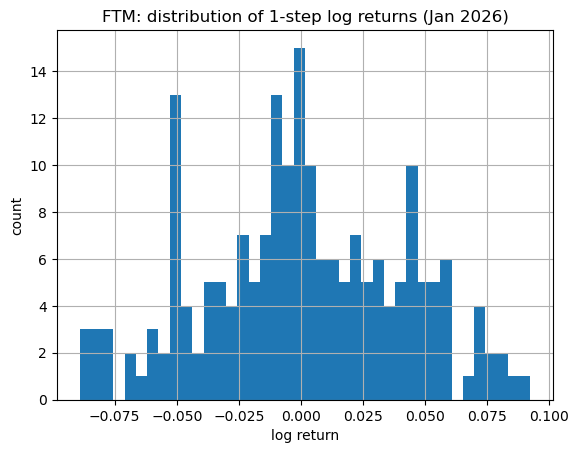

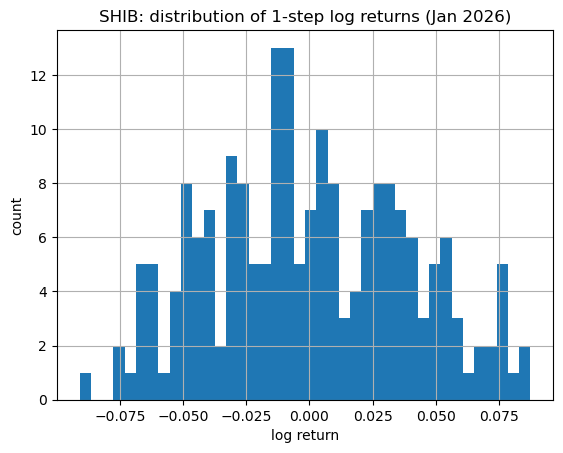

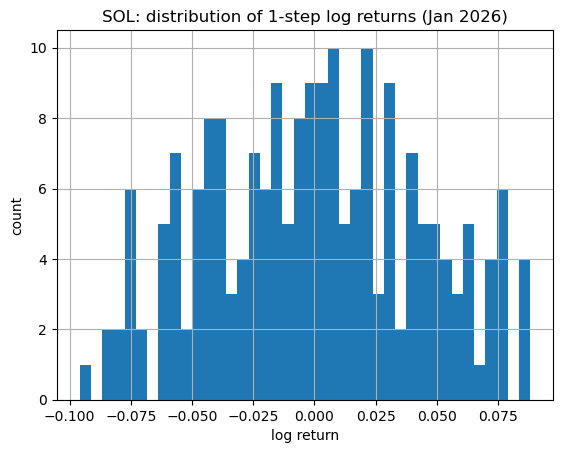

In [93]:

# 7) Price EDA + ALL PRICES ON ONE PLOT

if len(PRICE_JAN) == 0:
    print("\nNo price rows in Jan 2026 after filtering. Stop here.")
else:
    PRICE_JAN = PRICE_JAN.sort_values(["symbol", "event_timestamp"]).copy()

    # 7.1 One plot: RAW prices (log scale so ETH and SHIB can coexist)
    plt.figure()
    for sym in sorted(PRICE_JAN["symbol"].dropna().unique()):
        d = PRICE_JAN[PRICE_JAN["symbol"] == sym]
        plt.plot(d["event_timestamp"], d["price"], label=sym)
    plt.yscale("log")
    plt.title("All crypto prices on one plot (Jan 2026) - log scale")
    plt.xlabel("time")
    plt.ylabel("price (log scale)")
    plt.legend()
    plt.show()

    # 7.2 One plot: Normalized to 1 at first timestamp (easier to compare moves)
    plt.figure()
    for sym in sorted(PRICE_JAN["symbol"].dropna().unique()):
        d = PRICE_JAN[PRICE_JAN["symbol"] == sym].copy()
        if len(d) == 0:
            continue
        base = d["price"].iloc[0]
        if base == 0 or pd.isna(base):
            continue
        d["price_norm"] = d["price"] / base
        plt.plot(d["event_timestamp"], d["price_norm"], label=sym)
    plt.title("All crypto prices normalized (Jan 2026)")
    plt.xlabel("time")
    plt.ylabel("price / first_price")
    plt.legend()
    plt.show()

    # 7.3 Returns distributions
    PRICE_JAN["log_price"] = np.log(PRICE_JAN["price"])
    PRICE_JAN["ret_1step"] = PRICE_JAN.groupby("symbol")["log_price"].diff()

    for sym in sorted(PRICE_JAN["symbol"].dropna().unique()):
        d = PRICE_JAN[PRICE_JAN["symbol"] == sym]
        plt.figure()
        d["ret_1step"].dropna().hist(bins=40)
        plt.title(f"{sym}: distribution of 1-step log returns (Jan 2026)")
        plt.xlabel("log return")
        plt.ylabel("count")
        plt.show()


Missing ratio PRICE_JAN (top 10):
ret_1step          0.005025
symbol             0.000000
price              0.000000
timestamp          0.000000
event_timestamp    0.000000
log_price          0.000000
dtype: float64

Missing ratio TWEETS_JAN (top 10):
author_id         1.0
id                0.0
text              0.0
crypto_key        0.0
created_at_raw    0.0
created_at_iso    0.0
timestamp_ms      0.0
timestamp_sec     0.0
tweet_ts          0.0
symbol            0.0
dtype: float64

Duplicate text rate (TWEETS_JAN): 0.32094594594594594

Top duplicated texts (head 10):
text
$FTM Here we go...                                                                                                                                                                                                                                                                                                                                                                                                                

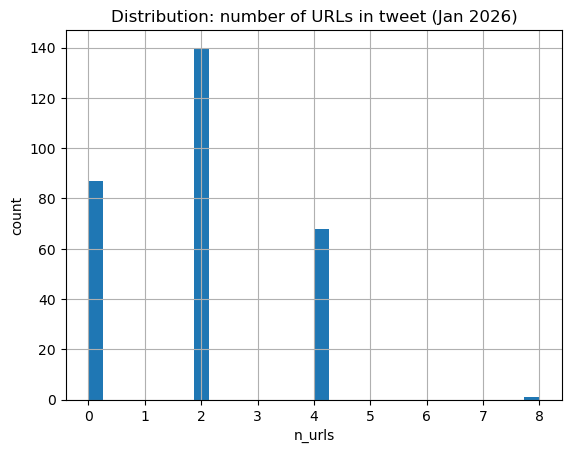

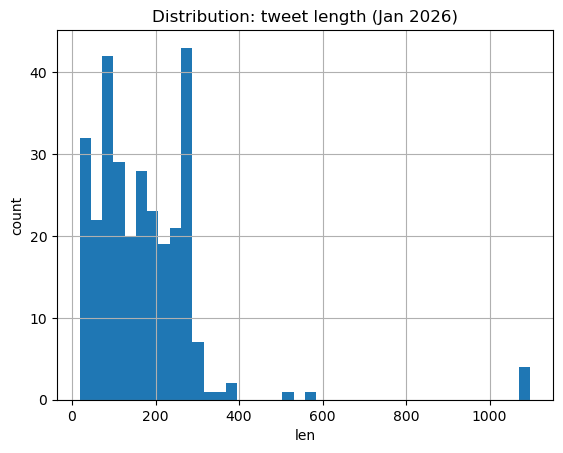


Share of tweets with numbers (Jan 2026): 0.40540540540540543


/var/folders/xg/gdrq_vp93cj1ps_x39psl1_00000gn/T/ipykernel_16165/2768533046.py:55: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  has_number = TWEETS_FE["text"].fillna("").str.contains(r"\b\d+(\.\d+)?\b")


In [94]:

# 8) Tweet EDA: missing, duplicates, spam-like signals

def basic_text_features(s):
    s = "" if pd.isna(s) else str(s)
    return pd.Series({
        "len": len(s),
        "n_words": len(s.split()),
        "n_urls": len(re.findall(r"http[s]?://|t\.co/", s)),
        "n_mentions": len(re.findall(r"@\w+", s)),
        "n_hashtags": len(re.findall(r"#\w+", s)),
        "n_cashtags": len(re.findall(r"\$\w+", s)),
        "has_call_to_action": int(bool(re.search(r"\bjoin\b|\bvip\b|\bfree signals\b|\blink\b|\btelegram\b", s.lower()))),
    })

print("\nMissing ratio PRICE_JAN (top 10):")
print(PRICE_JAN.isna().mean().sort_values(ascending=False).head(10))

print("\nMissing ratio TWEETS_JAN (top 10):")
print(TWEETS_JAN.isna().mean().sort_values(ascending=False).head(10))

if len(TWEETS_JAN) == 0:
    print("\nNo tweets in Jan 2026 after filtering.")
    TWEETS_FE = TWEETS_JAN.copy()
else:
    dup_rate = TWEETS_JAN["text"].duplicated().mean()
    print("\nDuplicate text rate (TWEETS_JAN):", float(dup_rate))

    print("\nTop duplicated texts (head 10):")
    print(TWEETS_JAN["text"].value_counts().head(10))

    TXT_FEATS = TWEETS_JAN["text"].apply(basic_text_features)
    TWEETS_FE = pd.concat([TWEETS_JAN.reset_index(drop=True), TXT_FEATS.reset_index(drop=True)], axis=1)

    # author_id is always missing in your output, so this will be 1.0 everywhere
    TWEETS_FE["author_id_is_null"] = TWEETS_FE["author_id"].isna().astype(int)

    cols = ["len","n_words","n_urls","n_hashtags","n_cashtags","has_call_to_action","author_id_is_null"]
    print("\nTweet feature means by symbol:")
    print(TWEETS_FE.groupby("symbol")[cols].mean().sort_index())

    plt.figure()
    TWEETS_FE["n_urls"].hist(bins=30)
    plt.title("Distribution: number of URLs in tweet (Jan 2026)")
    plt.xlabel("n_urls")
    plt.ylabel("count")
    plt.show()

    plt.figure()
    TWEETS_FE["len"].hist(bins=40)
    plt.title("Distribution: tweet length (Jan 2026)")
    plt.xlabel("len")
    plt.ylabel("count")
    plt.show()

    has_number = TWEETS_FE["text"].fillna("").str.contains(r"\b\d+(\.\d+)?\b")
    print("\nShare of tweets with numbers (Jan 2026):", float(has_number.mean()))



In [95]:
# 9) Aggregate tweets to bins and join with prices

# Price bins
PRICE_JAN["bin_ts"] = PRICE_JAN["event_timestamp"].dt.floor(BIN)
pbin = (PRICE_JAN.groupby(["symbol", "bin_ts"])
        .agg(price=("price", "last"))
        .reset_index()
        .sort_values(["symbol", "bin_ts"])
)
pbin["log_price"] = np.log(pbin["price"])
pbin["target_ret_next"] = pbin.groupby("symbol")["log_price"].diff().shift(-1)

# Tweet bins
if len(TWEETS_FE) > 0:
    TWEETS_FE["bin_ts"] = TWEETS_FE["tweet_ts"].dt.floor(BIN)

    agg = (TWEETS_FE.groupby(["symbol", "bin_ts"])
           .agg(
               tweet_count=("id", "count"),
               mean_len=("len", "mean"),
               mean_urls=("n_urls", "mean"),
               mean_cashtags=("n_cashtags", "mean"),
               share_cta=("has_call_to_action", "mean"),
           )
           .reset_index()
    )
else:
    agg = pd.DataFrame(columns=["symbol","bin_ts","tweet_count","mean_len","mean_urls","mean_cashtags","share_cta"])

# Join
DATA = (pbin.merge(agg, on=["symbol", "bin_ts"], how="left")
        .sort_values(["symbol", "bin_ts"])
)
for c in ["tweet_count","mean_len","mean_urls","mean_cashtags","share_cta"]:
    DATA[c] = DATA[c].fillna(0)

print("\nDATA shape:", DATA.shape)
print("Non-null targets:", int(DATA["target_ret_next"].notna().sum()))
display(DATA.head(10))


DATA shape: (16, 10)
Non-null targets: 12


,symbol,bin_ts,price,log_price,target_ret_next,tweet_count,mean_len,mean_urls,mean_cashtags,share_cta
0,ETH,2026-01-25 18:00:00+00:00,2856.862309,7.957479,-0.056439,0.0,0.0,0.0,0.0,0.0
1,ETH,2026-01-25 18:15:00+00:00,2700.088962,7.901040,-0.023082,1.0,42.0,2.0,1.0,0.0
2,ETH,2026-01-25 18:30:00+00:00,2638.480518,7.877958,0.014314,0.0,0.0,0.0,0.0,0.0
3,ETH,2026-01-25 18:45:00+00:00,2676.520549,7.892273,NaN,0.0,0.0,0.0,0.0,0.0
4,FTM,2026-01-25 18:00:00+00:00,0.104724,-2.256422,0.073365,1.0,215.0,2.0,0.0,0.0
5,FTM,2026-01-25 18:15:00+00:00,0.112696,-2.183058,-0.014060,0.0,0.0,0.0,0.0,0.0
6,FTM,2026-01-25 18:30:00+00:00,0.111123,-2.197117,0.008615,0.0,0.0,0.0,0.0,0.0
7,FTM,2026-01-25 18:45:00+00:00,0.112084,-2.188502,NaN,0.0,0.0,0.0,0.0,0.0
8,SHIB,2026-01-25 18:00:00+00:00,0.000008,-11.755515,-0.039479,0.0,0.0,0.0,0.0,0.0
9,SHIB,2026-01-25 18:15:00+00:00,0.000008,-11.794994,-0.010743,2.0,180.5,2.0,1.0,0.0


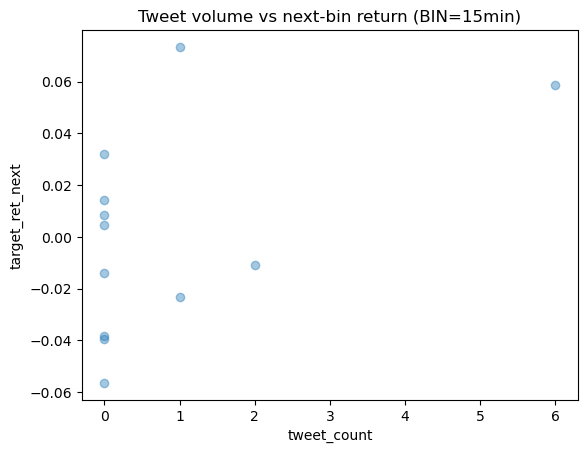

In [96]:

# 10) Visual: tweet volume vs next return

DF = DATA.dropna(subset=["target_ret_next"]).copy()
if len(DF) > 0:
    plt.figure()
    plt.scatter(DF["tweet_count"], DF["target_ret_next"], alpha=0.4)
    plt.title(f"Tweet volume vs next-bin return (BIN={BIN})")
    plt.xlabel("tweet_count")
    plt.ylabel("target_ret_next")
    plt.show()
else:
    print("\nNo rows with target_ret_next after binning. Try smaller BIN (e.g. '5min') or check coverage.")



In [97]:

# 11) Correlations (if enough rows)

num_cols = ["tweet_count","mean_len","mean_urls","mean_cashtags","share_cta","target_ret_next"]
if len(DF) >= 30:
    corr = DF[num_cols].corr(numeric_only=True)

    plt.figure()
    plt.imshow(corr, aspect="auto")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation heatmap (numeric features)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    print("\nCorrelation with target_ret_next:")
    print(corr["target_ret_next"].sort_values(ascending=False))
else:
    print(f"\nNot enough joined data for correlations (need ~30 rows, have {len(DF)}).")




Not enough joined data for correlations (need ~30 rows, have 12).


In [98]:

# 12) Lag correlation per symbol (if enough rows)

def lag_corr(df, x, y, max_lag=24):
    s = df.sort_values("bin_ts")
    out = []
    for lag in range(-max_lag, max_lag + 1):
        out.append((lag, s[x].shift(lag).corr(s[y])))
    return pd.DataFrame(out, columns=["lag", "corr"])

if len(DF) >= 30:
    for sym in sorted(DF["symbol"].dropna().unique()):
        d = DF[DF["symbol"] == sym].copy()
        if len(d) < 20:
            continue
        lc = lag_corr(d, "tweet_count", "target_ret_next", max_lag=24)
        plt.figure()
        plt.plot(lc["lag"], lc["corr"])
        plt.title(f"{sym}: lag corr tweet_count vs next return (BIN={BIN})")
        plt.xlabel("lag (bins)")
        plt.ylabel("corr")
        plt.show()
else:
    print("\nSkipping lag correlation (too few rows).")



Skipping lag correlation (too few rows).


In [99]:

# 13) Numeric baseline + permutation importance (if enough rows)

FEATS = ["tweet_count","mean_len","mean_urls","mean_cashtags","share_cta"]

if len(DF) >= 50:
    X = DF[FEATS]
    y = DF["target_ret_next"]

    tscv = TimeSeriesSplit(n_splits=5)
    model = Ridge(alpha=1.0)

    maes = []
    for tr, te in tscv.split(X):
        model.fit(X.iloc[tr], y.iloc[tr])
        pred = model.predict(X.iloc[te])
        maes.append(mean_absolute_error(y.iloc[te], pred))

    print("\nNumeric baseline Ridge")
    print("CV MAE:", float(np.mean(maes)), "+/-", float(np.std(maes)))

    model.fit(X, y)
    coefs = pd.Series(model.coef_, index=FEATS).sort_values(key=np.abs, ascending=False)
    print("\nRidge coefficients (abs-sorted):")
    print(coefs)

    pi = permutation_importance(model, X, y, n_repeats=20, random_state=42)
    imp = pd.Series(pi.importances_mean, index=FEATS).sort_values(ascending=False)

    plt.figure()
    imp.plot(kind="bar")
    plt.title("Permutation importance (numeric features)")
    plt.xlabel("feature")
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

    print("\nPermutation importance:")
    print(imp)
else:
    print(f"\nNot enough joined data for numeric baseline/importance (need ~50 rows, have {len(DF)}).")



Not enough joined data for numeric baseline/importance (need ~50 rows, have 12).


In [100]:

# 14) Text baseline: TF-IDF per bin + Ridge (if enough rows)

if len(TWEETS_FE) > 0:
    docs = (TWEETS_FE.groupby(["symbol","bin_ts"])["text"]
            .apply(lambda x: " ".join([t for t in x.dropna().astype(str).tolist()]))
            .reset_index()
            .rename(columns={"text":"doc"})
    )

    DFT = DATA.merge(docs, on=["symbol","bin_ts"], how="left")
    DFT["doc"] = DFT["doc"].fillna("")
    DFT = DFT.dropna(subset=["target_ret_next"]).copy()
    DFT = DFT.sort_values(["symbol","bin_ts"]).reset_index(drop=True)

    if len(DFT) >= 60:
        pipe = Pipeline([
            ("tfidf", TfidfVectorizer(
                min_df=3,
                max_df=0.9,
                ngram_range=(1,2),
                lowercase=True
            )),
            ("ridge", Ridge(alpha=5.0))
        ])

        tscv = TimeSeriesSplit(n_splits=5)
        maes = []
        for tr, te in tscv.split(DFT):
            pipe.fit(DFT.loc[tr, "doc"], DFT.loc[tr, "target_ret_next"])
            pred = pipe.predict(DFT.loc[te, "doc"])
            maes.append(mean_absolute_error(DFT.loc[te, "target_ret_next"], pred))

        print("\nText TF-IDF + Ridge")
        print("Text CV MAE:", float(np.mean(maes)), "+/-", float(np.std(maes)))

        pipe.fit(DFT["doc"], DFT["target_ret_next"])
        tfidf = pipe.named_steps["tfidf"]
        ridge = pipe.named_steps["ridge"]

        terms = np.array(tfidf.get_feature_names_out())
        weights = ridge.coef_

        top_pos = terms[np.argsort(weights)[-25:]][::-1]
        top_neg = terms[np.argsort(weights)[:25]]

        print("\nTop positive terms:")
        print(top_pos)

        print("\nTop negative terms:")
        print(top_neg)
    else:
        print(f"\nNot enough rows for TF-IDF baseline (need ~60 rows, have {len(DFT)}).")
else:
    print("\nNo tweets after filtering, skipping TF-IDF baseline.")




Not enough rows for TF-IDF baseline (need ~60 rows, have 12).


In [101]:

# 15) Spam filter preview (safe for your data)
# Only filter on call-to-action share, because author_id is always null in your dataset

if len(DATA) > 0:
    DATA_clean = DATA.copy()
    DATA_clean = DATA_clean[DATA_clean["share_cta"] < 0.5]

    print("\nSpam filter preview (share_cta < 0.5):")
    print("Rows before/after:", len(DATA), "->", len(DATA_clean))
else:
    print("\nNo joined data to filter.")

print("\nDONE.")



Spam filter preview (share_cta < 0.5):
Rows before/after: 16 -> 16

DONE.


# Dec 2025 - Jan 2026 (UTC) 

In [102]:

# 2) Time window: Dec 2025 - Jan 2026 (UTC)

JAN_START = pd.Timestamp("2025-12-01T00:00:00Z")
FEB_START = pd.Timestamp("2026-02-01T00:00:00Z")


# 3) Join bin size

BIN = "15min"   

# 4) Load data

PRICE = pd.read_csv(CSV_PATH)

def load_tweets(path):
    with open(path, "r") as f:
        data = json.load(f)
    return pd.DataFrame(data)

TWEETS = pd.concat([load_tweets(p) for p in TWEET_JSON_PATHS], ignore_index=True)

print("RAW PRICE:", PRICE.shape, "columns:", list(PRICE.columns))
print("RAW TWEETS:", TWEETS.shape, "columns:", list(TWEETS.columns))



# 5) Parse timestamps 
# PRICE.timestamp is epoch in milliseconds

if "timestamp" not in PRICE.columns:
    raise ValueError("PRICE must have column 'timestamp'. Found: " + str(list(PRICE.columns)))

PRICE["timestamp"] = pd.to_numeric(PRICE["timestamp"], errors="coerce")
PRICE["event_timestamp"] = pd.to_datetime(PRICE["timestamp"], unit="ms", utc=True, errors="coerce")

# Tweets
TWEETS["timestamp_ms"] = pd.to_numeric(TWEETS.get("timestamp_ms"), errors="coerce")
TWEETS["tweet_ts"] = pd.to_datetime(TWEETS["timestamp_ms"], unit="ms", utc=True, errors="coerce")
TWEETS["created_at_iso"] = pd.to_datetime(TWEETS.get("created_at_iso"), utc=True, errors="coerce")

# Map symbol
TWEETS["symbol"] = TWEETS.get("crypto_key")

print("\nParsed time ranges:")
print("PRICE:", PRICE["event_timestamp"].min(), "->", PRICE["event_timestamp"].max())
print("TWEETS:", TWEETS["tweet_ts"].min(), "->", TWEETS["tweet_ts"].max())



# 6) Filter 

PRICE_JAN = PRICE[(PRICE["event_timestamp"] >= JAN_START) & (PRICE["event_timestamp"] < FEB_START)].copy()
TWEETS_JAN = TWEETS[(TWEETS["tweet_ts"] >= JAN_START) & (TWEETS["tweet_ts"] < FEB_START)].copy()

print("\nJAN 2026 FILTER RESULTS")
print("PRICE_JAN:", PRICE_JAN.shape, "range:", PRICE_JAN["event_timestamp"].min(), "->", PRICE_JAN["event_timestamp"].max())
print("TWEETS_JAN:", TWEETS_JAN.shape, "range:", TWEETS_JAN["tweet_ts"].min(), "->", TWEETS_JAN["tweet_ts"].max())

print("\nSymbols in PRICE_JAN:", sorted(PRICE_JAN["symbol"].dropna().unique().tolist()) if "symbol" in PRICE_JAN.columns else "no symbol col")
print("Symbols in TWEETS_JAN:", sorted(TWEETS_JAN["symbol"].dropna().unique().tolist()))






RAW PRICE: (3444, 3) columns: ['symbol', 'price', 'timestamp']
RAW TWEETS: (468, 8) columns: ['id', 'text', 'author_id', 'crypto_key', 'created_at_raw', 'created_at_iso', 'timestamp_ms', 'timestamp_sec']

Parsed time ranges:
PRICE: 2025-11-23 21:41:44.894000+00:00 -> 2026-01-25 18:52:56.065000+00:00
TWEETS: 2024-03-15 13:41:53+00:00 -> 2026-01-25 18:29:26+00:00

JAN 2026 FILTER RESULTS
PRICE_JAN: (3316, 4) range: 2025-12-22 09:50:41.773000+00:00 -> 2026-01-25 18:52:56.065000+00:00
TWEETS_JAN: (399, 10) range: 2025-12-28 13:50:20+00:00 -> 2026-01-25 18:29:26+00:00

Symbols in PRICE_JAN: ['ETH', 'FTM', 'SHIB', 'SOL']
Symbols in TWEETS_JAN: ['ETH', 'FTM', 'HASH', 'SEE', 'SHIB', 'SOL']


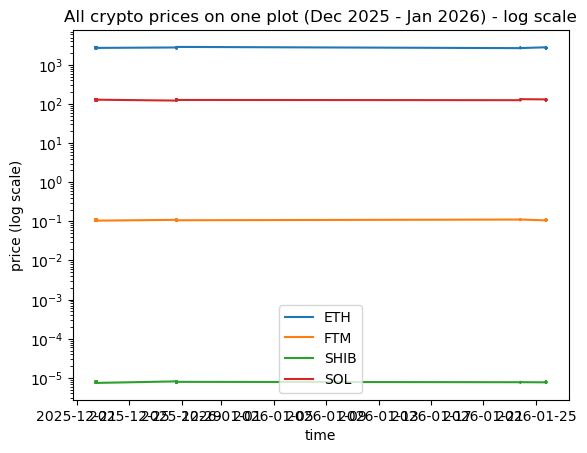

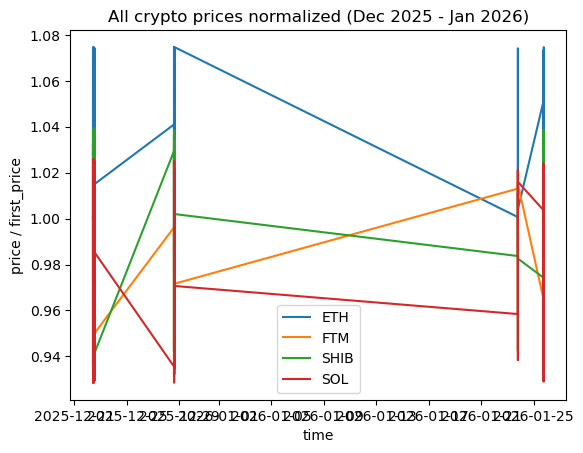

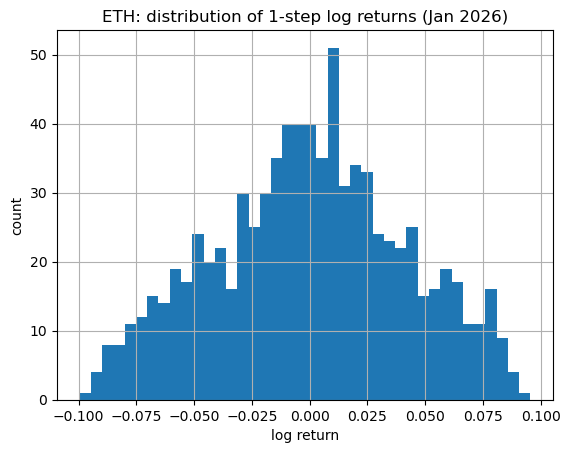

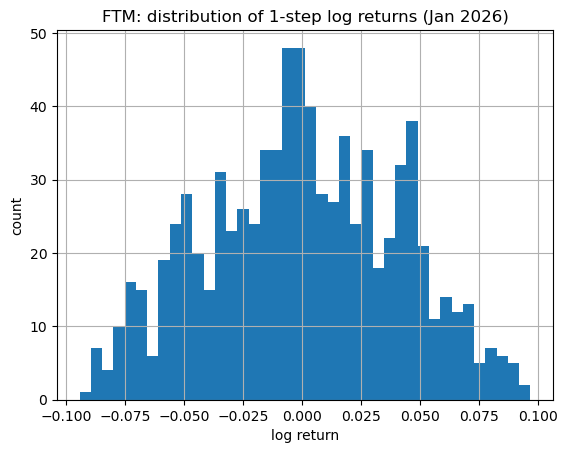

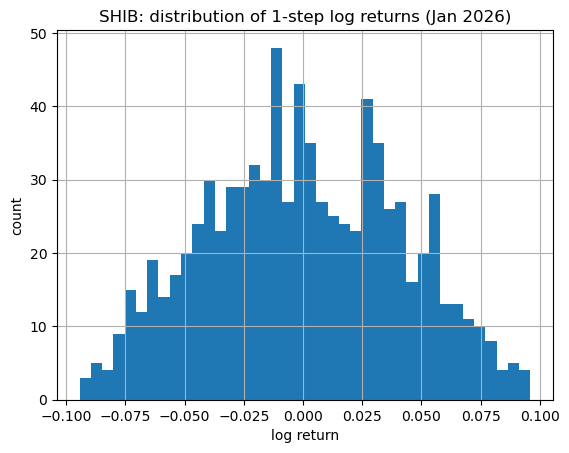

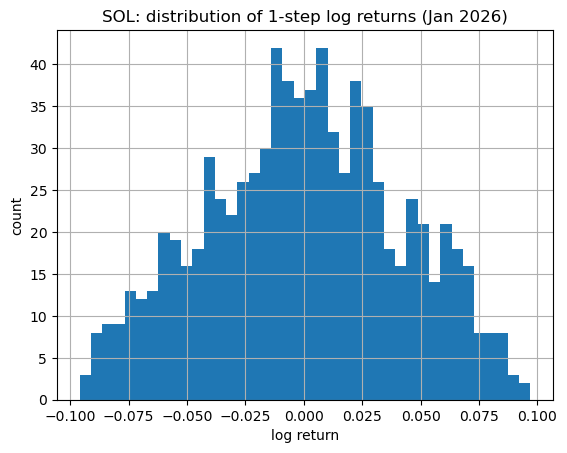


Missing ratio PRICE_JAN (top 10):
ret_1step          0.001206
symbol             0.000000
price              0.000000
timestamp          0.000000
event_timestamp    0.000000
log_price          0.000000
dtype: float64

Missing ratio TWEETS_JAN (top 10):
author_id         1.000000
crypto_key        0.005013
symbol            0.005013
id                0.000000
text              0.000000
created_at_raw    0.000000
created_at_iso    0.000000
timestamp_ms      0.000000
timestamp_sec     0.000000
tweet_ts          0.000000
dtype: float64

Duplicate text rate (TWEETS_JAN): 0.2681704260651629

Top duplicated texts (head 10):
text
$FTM Here we go...                                                                                                                                                                                                                                                                                                                                                               

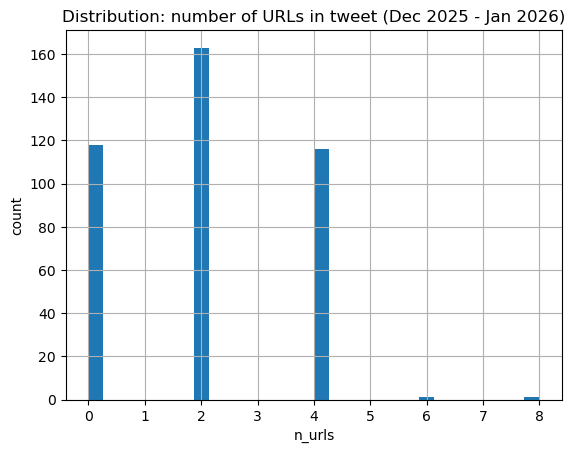

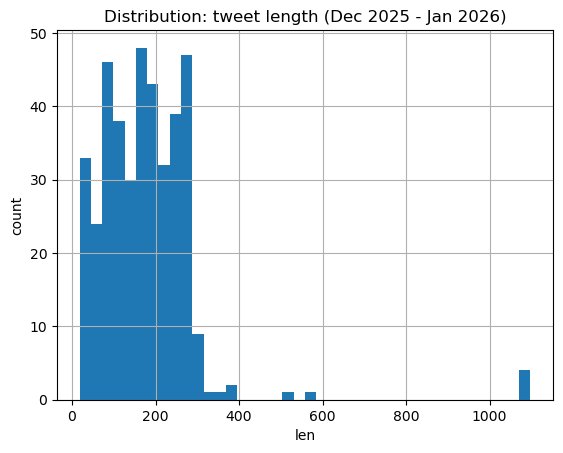


Share of tweets with numbers (Jan 2026): 0.46365914786967416


/var/folders/xg/gdrq_vp93cj1ps_x39psl1_00000gn/T/ipykernel_16165/2795766675.py:106: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  has_number = TWEETS_FE["text"].fillna("").str.contains(r"\b\d+(\.\d+)?\b")


In [103]:
# 7) Price EDA + ALL PRICES ON ONE PLOT

if len(PRICE_JAN) == 0:
    print("\nNo price rows in Jan 2026 after filtering. Stop here.")
else:
    PRICE_JAN = PRICE_JAN.sort_values(["symbol", "event_timestamp"]).copy()

    # 7.1 One plot: RAW prices (log scale so ETH and SHIB can coexist)
    plt.figure()
    for sym in sorted(PRICE_JAN["symbol"].dropna().unique()):
        d = PRICE_JAN[PRICE_JAN["symbol"] == sym]
        plt.plot(d["event_timestamp"], d["price"], label=sym)
    plt.yscale("log")
    plt.title("All crypto prices on one plot (Dec 2025 - Jan 2026) - log scale")
    plt.xlabel("time")
    plt.ylabel("price (log scale)")
    plt.legend()
    plt.show()

    # 7.2 One plot: Normalized to 1 at first timestamp (easier to compare moves)
    plt.figure()
    for sym in sorted(PRICE_JAN["symbol"].dropna().unique()):
        d = PRICE_JAN[PRICE_JAN["symbol"] == sym].copy()
        if len(d) == 0:
            continue
        base = d["price"].iloc[0]
        if base == 0 or pd.isna(base):
            continue
        d["price_norm"] = d["price"] / base
        plt.plot(d["event_timestamp"], d["price_norm"], label=sym)
    plt.title("All crypto prices normalized (Dec 2025 - Jan 2026)")
    plt.xlabel("time")
    plt.ylabel("price / first_price")
    plt.legend()
    plt.show()

    # 7.3 Returns distributions
    PRICE_JAN["log_price"] = np.log(PRICE_JAN["price"])
    PRICE_JAN["ret_1step"] = PRICE_JAN.groupby("symbol")["log_price"].diff()

    for sym in sorted(PRICE_JAN["symbol"].dropna().unique()):
        d = PRICE_JAN[PRICE_JAN["symbol"] == sym]
        plt.figure()
        d["ret_1step"].dropna().hist(bins=40)
        plt.title(f"{sym}: distribution of 1-step log returns (Jan 2026)")
        plt.xlabel("log return")
        plt.ylabel("count")
        plt.show()



# 8) Tweet EDA: missing, duplicates, spam-like signals

def basic_text_features(s):
    s = "" if pd.isna(s) else str(s)
    return pd.Series({
        "len": len(s),
        "n_words": len(s.split()),
        "n_urls": len(re.findall(r"http[s]?://|t\.co/", s)),
        "n_mentions": len(re.findall(r"@\w+", s)),
        "n_hashtags": len(re.findall(r"#\w+", s)),
        "n_cashtags": len(re.findall(r"\$\w+", s)),
        "has_call_to_action": int(bool(re.search(r"\bjoin\b|\bvip\b|\bfree signals\b|\blink\b|\btelegram\b", s.lower()))),
    })

print("\nMissing ratio PRICE_JAN (top 10):")
print(PRICE_JAN.isna().mean().sort_values(ascending=False).head(10))

print("\nMissing ratio TWEETS_JAN (top 10):")
print(TWEETS_JAN.isna().mean().sort_values(ascending=False).head(10))

if len(TWEETS_JAN) == 0:
    print("\nNo tweets in Jan 2026 after filtering.")
    TWEETS_FE = TWEETS_JAN.copy()
else:
    dup_rate = TWEETS_JAN["text"].duplicated().mean()
    print("\nDuplicate text rate (TWEETS_JAN):", float(dup_rate))

    print("\nTop duplicated texts (head 10):")
    print(TWEETS_JAN["text"].value_counts().head(10))

    TXT_FEATS = TWEETS_JAN["text"].apply(basic_text_features)
    TWEETS_FE = pd.concat([TWEETS_JAN.reset_index(drop=True), TXT_FEATS.reset_index(drop=True)], axis=1)

    # author_id is always missing in your output, so this will be 1.0 everywhere
    TWEETS_FE["author_id_is_null"] = TWEETS_FE["author_id"].isna().astype(int)

    cols = ["len","n_words","n_urls","n_hashtags","n_cashtags","has_call_to_action","author_id_is_null"]
    print("\nTweet feature means by symbol:")
    print(TWEETS_FE.groupby("symbol")[cols].mean().sort_index())

    plt.figure()
    TWEETS_FE["n_urls"].hist(bins=30)
    plt.title("Distribution: number of URLs in tweet (Dec 2025 - Jan 2026)")
    plt.xlabel("n_urls")
    plt.ylabel("count")
    plt.show()

    plt.figure()
    TWEETS_FE["len"].hist(bins=40)
    plt.title("Distribution: tweet length (Dec 2025 - Jan 2026)")
    plt.xlabel("len")
    plt.ylabel("count")
    plt.show()

    has_number = TWEETS_FE["text"].fillna("").str.contains(r"\b\d+(\.\d+)?\b")
    print("\nShare of tweets with numbers (Jan 2026):", float(has_number.mean()))






DATA shape: (72, 9)
Non-null targets: 68


,symbol,bin_ts,price,log_price,target_ret_next,tweet_count,mean_len,mean_urls,mean_cashtags
0,ETH,2025-12-22 09:45:00+00:00,2714.841873,7.906489,-0.033689,0.0,0.0,0.0,0.0
1,ETH,2025-12-22 10:00:00+00:00,2624.904250,7.872800,-0.009648,0.0,0.0,0.0,0.0
2,ETH,2025-12-22 10:15:00+00:00,2599.700505,7.863152,0.034947,0.0,0.0,0.0,0.0
3,ETH,2025-12-22 10:30:00+00:00,2692.157270,7.898098,0.012151,0.0,0.0,0.0,0.0
4,ETH,2025-12-22 10:45:00+00:00,2725.068860,7.910249,0.020140,0.0,0.0,0.0,0.0
5,ETH,2025-12-22 11:00:00+00:00,2780.508812,7.930389,-0.033956,0.0,0.0,0.0,0.0
6,ETH,2025-12-22 11:15:00+00:00,2687.677676,7.896433,0.010017,0.0,0.0,0.0,0.0
7,ETH,2025-12-22 11:30:00+00:00,2714.735369,7.906450,0.020046,0.0,0.0,0.0,0.0
8,ETH,2025-12-22 12:30:00+00:00,2769.705338,7.926496,-0.020847,0.0,0.0,0.0,0.0
9,ETH,2025-12-22 12:45:00+00:00,2712.562380,7.905649,-0.016425,0.0,0.0,0.0,0.0


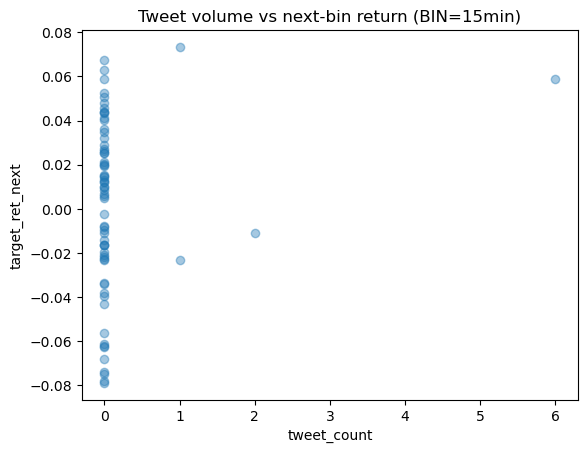

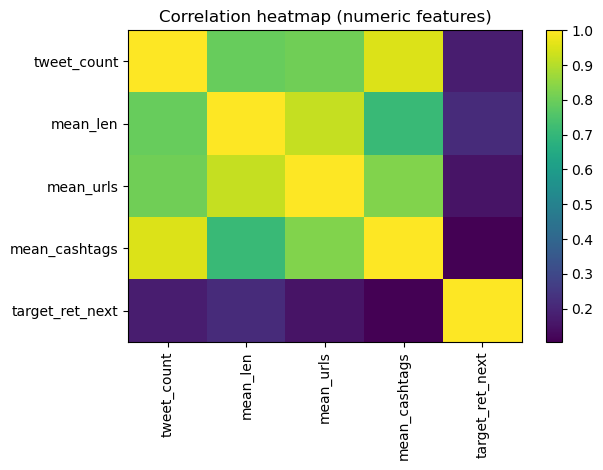


Correlation with target_ret_next:
target_ret_next    1.000000
mean_len           0.214118
tweet_count        0.176922
mean_urls          0.153738
mean_cashtags      0.104898
Name: target_ret_next, dtype: float64


In [104]:
# 9) Aggregate tweets to bins and join with prices

# Price bins
PRICE_JAN["bin_ts"] = PRICE_JAN["event_timestamp"].dt.floor(BIN)
pbin = (PRICE_JAN.groupby(["symbol", "bin_ts"])
        .agg(price=("price", "last"))
        .reset_index()
        .sort_values(["symbol", "bin_ts"])
)
pbin["log_price"] = np.log(pbin["price"])
pbin["target_ret_next"] = pbin.groupby("symbol")["log_price"].diff().shift(-1)

# Tweet bins
if len(TWEETS_FE) > 0:
    TWEETS_FE["bin_ts"] = TWEETS_FE["tweet_ts"].dt.floor(BIN)

    agg = (TWEETS_FE.groupby(["symbol", "bin_ts"])
           .agg(
               tweet_count=("id", "count"),
               mean_len=("len", "mean"),
               mean_urls=("n_urls", "mean"),
               mean_cashtags=("n_cashtags", "mean"),
              # share_cta=("has_call_to_action", "mean"),
           )
           .reset_index()
    )
else:
    agg = pd.DataFrame(columns=["symbol","bin_ts","tweet_count","mean_len","mean_urls","mean_cashtags"])

# Join
DATA = (pbin.merge(agg, on=["symbol", "bin_ts"], how="left")
        .sort_values(["symbol", "bin_ts"])
)
for c in ["tweet_count","mean_len","mean_urls","mean_cashtags"]:
    DATA[c] = DATA[c].fillna(0)

print("\nDATA shape:", DATA.shape)
print("Non-null targets:", int(DATA["target_ret_next"].notna().sum()))
display(DATA.head(10))



# 10) Visual: tweet volume vs next return

DF = DATA.dropna(subset=["target_ret_next"]).copy()
if len(DF) > 0:
    plt.figure()
    plt.scatter(DF["tweet_count"], DF["target_ret_next"], alpha=0.4)
    plt.title(f"Tweet volume vs next-bin return (BIN={BIN})")
    plt.xlabel("tweet_count")
    plt.ylabel("target_ret_next")
    plt.show()
else:
    print("\nNo rows with target_ret_next after binning. Try smaller BIN (e.g. '5min') or check coverage.")



# 11) Correlations (if enough rows)

num_cols = ["tweet_count","mean_len","mean_urls","mean_cashtags","target_ret_next"]
if len(DF) >= 30:
    corr = DF[num_cols].corr(numeric_only=True)

    plt.figure()
    plt.imshow(corr, aspect="auto")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation heatmap (numeric features)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    print("\nCorrelation with target_ret_next:")
    print(corr["target_ret_next"].sort_values(ascending=False))
else:
    print(f"\nNot enough joined data for correlations (need ~30 rows, have {len(DF)}).")



# 12) Lag correlation per symbol (if enough rows)

def lag_corr(df, x, y, max_lag=24):
    s = df.sort_values("bin_ts")
    out = []
    for lag in range(-max_lag, max_lag + 1):
        out.append((lag, s[x].shift(lag).corr(s[y])))
    return pd.DataFrame(out, columns=["lag", "corr"])

if len(DF) >= 30:
    for sym in sorted(DF["symbol"].dropna().unique()):
        d = DF[DF["symbol"] == sym].copy()
        if len(d) < 20:
            continue
        lc = lag_corr(d, "tweet_count", "target_ret_next", max_lag=24)
        plt.figure()
        plt.plot(lc["lag"], lc["corr"])
        plt.title(f"{sym}: lag corr tweet_count vs next return (BIN={BIN})")
        plt.xlabel("lag (bins)")
        plt.ylabel("corr")
        plt.show()
else:
    print("\nSkipping lag correlation (too few rows).")






Numeric baseline Ridge
CV MAE: 0.038580878628550176 +/- 0.007960632781071546

Ridge coefficients (abs-sorted):
mean_cashtags   -0.018538
mean_urls       -0.011881
tweet_count      0.009577
mean_len         0.000293
dtype: float64


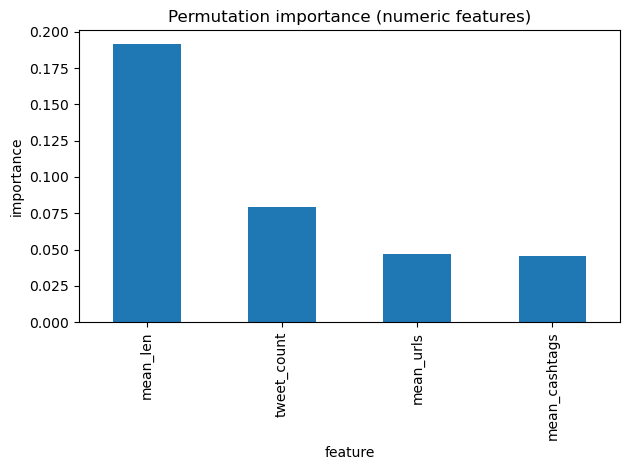


Permutation importance:
mean_len         0.191496
tweet_count      0.079111
mean_urls        0.046780
mean_cashtags    0.045320
dtype: float64


In [105]:
# 13) Numeric baseline + permutation importance (if enough rows)

FEATS = ["tweet_count","mean_len","mean_urls","mean_cashtags"]

if len(DF) >= 50:
    X = DF[FEATS]
    y = DF["target_ret_next"]

    tscv = TimeSeriesSplit(n_splits=5)
    model = Ridge(alpha=1.0)

    maes = []
    for tr, te in tscv.split(X):
        model.fit(X.iloc[tr], y.iloc[tr])
        pred = model.predict(X.iloc[te])
        maes.append(mean_absolute_error(y.iloc[te], pred))

    print("\nNumeric baseline Ridge")
    print("CV MAE:", float(np.mean(maes)), "+/-", float(np.std(maes)))

    model.fit(X, y)
    coefs = pd.Series(model.coef_, index=FEATS).sort_values(key=np.abs, ascending=False)
    print("\nRidge coefficients (abs-sorted):")
    print(coefs)

    pi = permutation_importance(model, X, y, n_repeats=20, random_state=42)
    imp = pd.Series(pi.importances_mean, index=FEATS).sort_values(ascending=False)

    plt.figure()
    imp.plot(kind="bar")
    plt.title("Permutation importance (numeric features)")
    plt.xlabel("feature")
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

    print("\nPermutation importance:")
    print(imp)
else:
    print(f"\nNot enough joined data for numeric baseline/importance (need ~50 rows, have {len(DF)}).")



